In [ ]:
!pip install pymorphy2
!pip install -U xgboost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_train = pd.read_csv('kagle_train.csv.zip', sep=',', parse_dates=['start_time'])
data_test = pd.read_csv('regr_test.csv.zip', sep=',', parse_dates=['start_time'])

In [5]:
data_train.head()

,id,start_time,title,price,item_id,owner_type,category,subcategory,param1,param2,param3,region,item_views
0,328853,2016-12-27 10:38:04,Сандали фирмы Crocs,800,1301822498390501359,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Москва,3.332205
1,257639,2016-12-27 15:23:55,Бутсы футбольные Reebok,2000,4439620035274845039,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Омская область,2.302585
2,140732,2016-12-28 19:34:15,Nike hypervenom Бутсы,600,4860577743813309218,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Санкт-Петербург,4.663439
3,3080,2016-12-26 10:26:02,Сапоги,150,3492530336858889466,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Тульская область,3.367296
4,325394,2016-12-26 17:09:19,Кеды 38,500,3559049054931858928,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Самарская область,2.302585


In [4]:
data_test.head()

,id,start_time,title,price,item_id,owner_type,category,subcategory,param1,param2,param3,region
0,161539,2016-12-27 14:17:05,"Ботинки демисезонные, р.37",600,4610800469053457977,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Челябинская область
1,72401,2016-12-26 23:07:52,Туфли,500,167053365292217626,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Волгоградская область
2,387692,2016-12-27 16:15:48,Cноубутсы новые 38р. по стельке 36 см. (больше...,1700,6201427797126202158,Company,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Нижегородская область
3,163041,2016-12-26 17:28:05,Зимние ботинки,400,3709484910019914672,Private,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Москва
4,367881,2016-12-26 20:43:19,Сандали новые,500,8208136942732978933,Company,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,> 36,Нижегородская область


In [6]:
data_train.describe()

,id,price,item_id,item_views
count,376687.000000,3.766870e+05,3.766870e+05,376687.000000
mean,211784.700144,2.465498e+05,4.606439e+18,3.483459
std,122355.459807,1.126163e+07,2.663233e+18,1.019757
min,0.000000,0.000000e+00,6.694595e+13,0.000000
25%,105786.500000,5.000000e+02,2.296781e+18,2.708050
50%,211758.000000,2.000000e+03,4.606254e+18,3.367296
75%,317745.500000,9.990000e+03,6.912617e+18,4.094345
max,423771.000000,5.677568e+09,9.223325e+18,8.328693


In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376687 entries, 0 to 376686
Data columns (total 13 columns):
id             376687 non-null int64
start_time     376687 non-null datetime64[ns]
title          376687 non-null object
price          376687 non-null int64
item_id        376687 non-null int64
owner_type     376687 non-null object
category       376687 non-null object
subcategory    376687 non-null object
param1         361456 non-null object
param2         196112 non-null object
param3         147746 non-null object
region         376687 non-null object
item_views     376687 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(8)
memory usage: 37.4+ MB


In [8]:
data_train = data_train.fillna('nan')
data_test = data_test.fillna('nan')

In [9]:
np.any(data_train.isna())

False

In [10]:
f = lambda x: (x.hour * 60 + x.minute) / (24 * 60)
data_train['relative_time'] = data_train.start_time.apply(f)
data_test['relative_time'] = data_test.start_time.apply(f)

In [11]:
data_train['time_to_end'] = data_train.start_time.apply(lambda x: 24 - x.hour)
data_test['time_to_end'] = data_test.start_time.apply(lambda x: 24 - x.hour)

In [12]:
data_train['slided_hours'] = data_train.start_time.apply(lambda x: ((x.hour - 3.5) % 24) * 1. / 24.)
data_test['slided_hours'] = data_test.start_time.apply(lambda x: ((x.hour - 3.5) % 24) * 1. / 24.)

In [13]:
def make_harmonic_features(value, period=24):
    value = (value / period) * 2 * np.pi
    return np.cos(value), np.sin(value)

In [14]:
data_train['cos_time'] = data_train.start_time.apply(lambda x: make_harmonic_features(x.hour + x.minute / 60)[0])
data_train['sin_time'] = data_train.start_time.apply(lambda x: make_harmonic_features(x.hour + x.minute / 60)[0])

data_test['cos_time'] = data_test.start_time.apply(lambda x: make_harmonic_features(x.hour + x.minute / 60)[0])
data_test['sin_time'] = data_test.start_time.apply(lambda x: make_harmonic_features(x.hour + x.minute / 60)[0])

In [15]:
data_train['week_day'] = data_train.start_time.apply(lambda x: x.isoweekday())
data_test['week_day'] = data_test.start_time.apply(lambda x: x.isoweekday())

In [16]:
data_train = data_train.drop(['start_time'], axis=1)
data_test = data_test.drop(['start_time'], axis=1)

##### текст

In [17]:
# !pip install pymorphy2

import re
import pymorphy2
from functools import lru_cache

In [18]:
morph = pymorphy2.MorphAnalyzer()

In [19]:
morph.parse('сладенькая')

[Parse(word='сладенькая', tag=OpencorporaTag('ADJF femn,sing,nomn'), normal_form='сладенький', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'сладенькая', 16, 7),))]

In [20]:
morph.get_lexeme(morph.parse('сладенькая')[0])

[Parse(word='сладенький', tag=OpencorporaTag('ADJF masc,sing,nomn'), normal_form='сладенький', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'сладенький', 16, 0),)),
 Parse(word='сладенького', tag=OpencorporaTag('ADJF masc,sing,gent'), normal_form='сладенький', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'сладенького', 16, 1),)),
 Parse(word='сладенькому', tag=OpencorporaTag('ADJF masc,sing,datv'), normal_form='сладенький', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'сладенькому', 16, 2),)),
 Parse(word='сладенького', tag=OpencorporaTag('ADJF anim,masc,sing,accs'), normal_form='сладенький', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'сладенького', 16, 3),)),
 Parse(word='сладенький', tag=OpencorporaTag('ADJF inan,masc,sing,accs'), normal_form='сладенький', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'сладенький', 16, 4),)),
 Parse(word='сладеньким', tag=OpencorporaTag('ADJF masc,sing,ablt'), normal_form='сладенький', score=1.0, methods_stack=((<DictionaryAnalyz

In [21]:
morph.normal_forms('чехлы'), morph.normal_forms('сладкая')

(['чехол'], ['сладкий'])

In [22]:
@lru_cache(maxsize=150000) # с кешом!
def get_normal_form (i):
    return morph.normal_forms(i)[0]

def normalize_text(x):
    return ' '.join([get_normal_form(i) for i in re.findall('\w+', x)])

In [23]:
normalize_text('Детская одежда и обувь')

'детский одежда и обувь'

In [24]:
from multiprocessing import Pool

In [25]:
%%time
with Pool(processes=4) as pool:
    data_train['title'] = pool.map(normalize_text, data_train.title)
    data_test['title'] = pool.map(normalize_text, data_test.title)
    pool.terminate()

CPU times: user 475 ms, sys: 147 ms, total: 622 ms
Wall time: 27.6 s


##### Куча категориальных признаков

In [26]:
# конкатенация строк
data_train['all_params'] = data_train.param1 + ' ' + data_train.param2 + ' ' + data_train.param3
data_train['params_12'] = data_train.param1 + ' ' + data_train.param2
data_train['params_23'] = data_train.param2 + ' ' + data_train.param3
data_train['category_and_owner_type'] = data_train.owner_type + ' ' + data_train.category
data_train['category_and_region'] = data_train.region + ' ' + data_train.category
data_train['owner_type_and_region'] = data_train.owner_type + ' ' + data_train.category

data_test['all_params'] = data_test.param1 + ' ' + data_test.param2 + ' ' + data_test.param3
data_test['params_12'] = data_test.param1 + ' ' + data_test.param2
data_test['params_23'] = data_test.param2 + ' ' + data_test.param3
data_test['category_and_owner_type'] = data_test.owner_type + ' ' + data_test.category
data_test['category_and_region'] = data_test.region + ' ' + data_test.category
data_test['owner_type_and_region'] = data_test.owner_type + ' ' + data_test.category

str_cols = ['owner_type', 'title',
            'param1', 'param2', 'param3',
            'region', 'category' , 'subcategory', 
            'params_12', 'params_23', 'all_params',
            'category_and_owner_type',
            'category_and_region', 'owner_type_and_region'
           ]

In [27]:
pd.options.display.max_columns = 50

In [28]:
data_train.columns

Index(['id', 'title', 'price', 'item_id', 'owner_type', 'category',
       'subcategory', 'param1', 'param2', 'param3', 'region', 'item_views',
       'relative_time', 'time_to_end', 'slided_hours', 'cos_time', 'sin_time',
       'week_day', 'all_params', 'params_12', 'params_23',
       'category_and_owner_type', 'category_and_region',
       'owner_type_and_region'],
      dtype='object')

In [29]:
X_train, y_train = data_train.drop(['item_views', 'id', 'item_id'], axis=1), data_train['item_views'].values
X_test = data_test.drop(['id', 'item_id'], axis=1)

In [30]:
def _counter_encoder(dt, str_cols, counter_Encoders, is_train=True):
    """
    Counter Encoder.
    """
    if is_train:
        counter_Encoders = {col:dt[col].value_counts().to_dict() for col in str_cols}
        
    for column in str_cols:
        dt[column+'_enc_by_count'] = dt[column].apply(lambda x: counter_Encoders[column].get(x, 0))
        
    return counter_Encoders

In [31]:
counter_Encoders = _counter_encoder(X_train, str_cols=str_cols, counter_Encoders=None, is_train=True)

In [32]:
_ = _counter_encoder(X_test, str_cols=str_cols, counter_Encoders=counter_Encoders, is_train=False)

In [33]:
# выкинем не интересное

X_train = X_train.drop(str_cols, axis=1)
X_test = X_test.drop(str_cols, axis=1)

____________-

> Как запустить XGBoost?

https://xgboost.readthedocs.io/en/latest/parameter.html

In [60]:
xgb_params = {
    'objective': 'reg:linear',
    'max_depth': 5,
    'eta': 0.12,
    'booster': 'gbtree',
    
    'alpha': 2.0,
    'lambda': 0.1,
    
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 1.0,
    
    'silent': 1,
    'seed': 1,
    'nthread': 4,
    'eval_metric':'rmse'
}

num_rounds = 150

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
X_sub_train, X_sub_train_test, y_sub_train, y_sub_train_test = train_test_split(
                        X_train, y_train, test_size=0.10, random_state=42)

In [63]:
import xgboost as xgb

In [64]:
dtrain = xgb.DMatrix( X_sub_train.values, label=y_sub_train, feature_names=X_sub_train.columns )
dtest = xgb.DMatrix( X_sub_train_test.values, label=y_sub_train_test, feature_names=X_sub_train_test.columns )

watchlist = [(dtrain, 'train'), (dtest, 'eval')]
eval_res ={}
gbdt = xgb.train(xgb_params, dtrain,
                 num_rounds, watchlist,
                 early_stopping_rounds=5,
                 verbose_eval=10,
                 evals_result=eval_res)


[0]	train-rmse:2.79725	eval-rmse:2.80595
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 5 rounds.
[10]	train-rmse:1.04085	eval-rmse:1.04942
[20]	train-rmse:0.723153	eval-rmse:0.731146
[30]	train-rmse:0.679588	eval-rmse:0.687189
[40]	train-rmse:0.662758	eval-rmse:0.670162
[50]	train-rmse:0.654801	eval-rmse:0.661955
[60]	train-rmse:0.64846	eval-rmse:0.655661
[70]	train-rmse:0.642452	eval-rmse:0.649431
[80]	train-rmse:0.638279	eval-rmse:0.644857
[90]	train-rmse:0.634424	eval-rmse:0.6411
[100]	train-rmse:0.631176	eval-rmse:0.638015
[110]	train-rmse:0.628247	eval-rmse:0.635274
[120]	train-rmse:0.625671	eval-rmse:0.632813
[130]	train-rmse:0.62375	eval-rmse:0.631119
[140]	train-rmse:0.621735	eval-rmse:0.629324


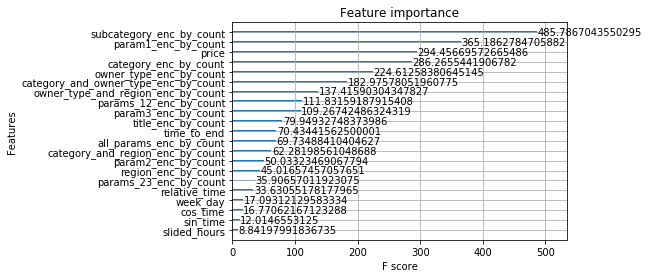

In [65]:
xgb.plot_importance(gbdt, importance_type='gain')

In [66]:
dtest_final = xgb.DMatrix( X_test.values, feature_names=X_test.columns )

y_pred = gbdt.predict(dtest_final)

pd.DataFrame({'id': data_test.id, 'item_views':y_pred}).to_csv('my_sample_pred1.csv', index=None)

> долго. Как можно лучше? (попробовать подобрать параметры на подвыборке !но увеличить subsamples)

фиксируем число деревьев, глубину и подбираем ленинг рейт. (по дефолту в нем уже есть регуляризация)

после подбора можно уже слегка побороться за уменьшение дисперсии  (если у вас очень шумные данные покрутить лямбду и альфу) 
покрутить сабсемплы по выборке, сабфичи по уровням и деревьям.
(не забудь зафиксировать seed для воспроизводимости если используются subsamples.)

##### Можно Лучше. Градиентный бустинг хорош когда признаки разной природы